In [1]:
import matplotlib.pyplot as plt

from map_environment import MapEnvironment, Point2D, create_sample_map
from pathfinding import find_grid_path
from visibility import compute_path_visibility, compute_visibility_polygon
from visualization import (
    plot_all_visibility,
    plot_grid,
    plot_map,
    plot_path,
    plot_visibility,
)

## Step 1 -- Create the Map with Obstacles

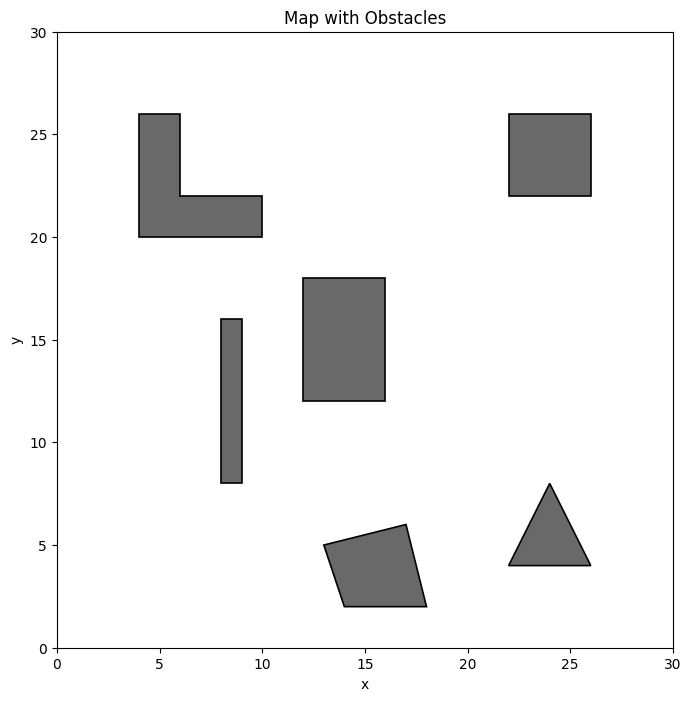

In [2]:
map_env: MapEnvironment = create_sample_map()

fig, ax = plt.subplots(figsize=(8, 8))
plot_map(ax, map_env)
plt.show()

## Step 2 -- Grid Overlay

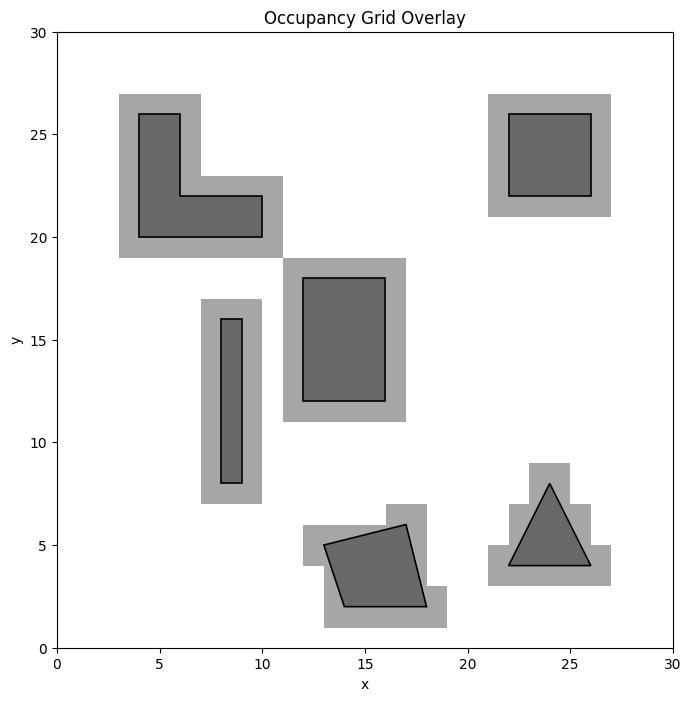

In [3]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_map(ax, map_env)
plot_grid(ax, map_env)
plt.show()

## Step 3 -- A* Pathfinding

Path found with 34 waypoints.


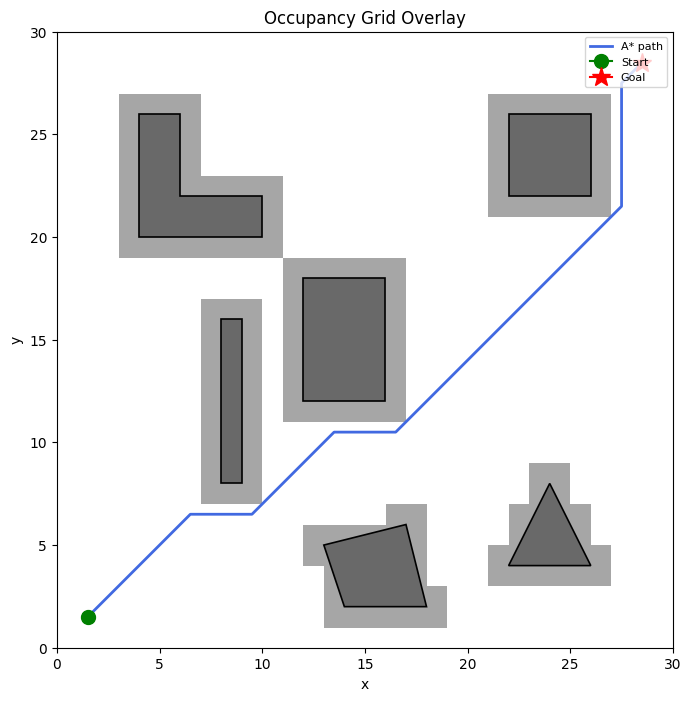

In [4]:
start: Point2D = Point2D(1.0, 1.0)
goal: Point2D = Point2D(28.0, 28.0)

path: list[Point2D] | None = find_grid_path(map_env, start, goal)

if path is None:
    print("No path found!")
else:
    print(f"Path found with {len(path)} waypoints.")

    fig, ax = plt.subplots(figsize=(8, 8))
    plot_map(ax, map_env)
    plot_grid(ax, map_env)
    plot_path(ax, path)
    plt.show()

## Step 4 -- Visibility at Key Waypoints

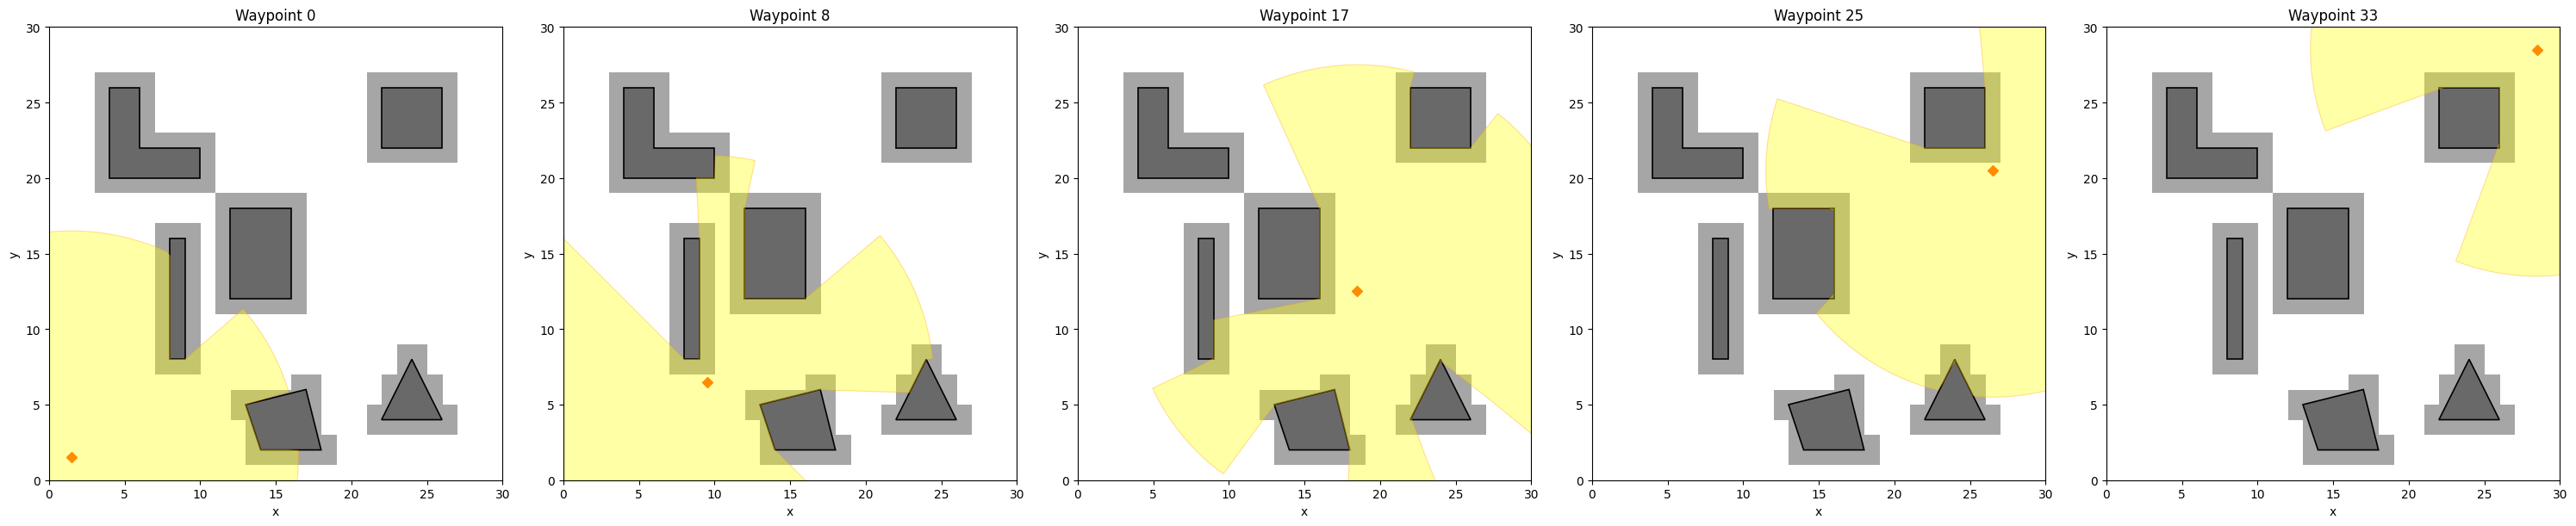

In [5]:
assert path is not None, "Path must exist for visibility computation."

# Pick a few representative waypoints: start, 1/4, 1/2, 3/4, end
indices: list[int] = [
    0,
    len(path) // 4,
    len(path) // 2,
    3 * len(path) // 4,
    len(path) - 1,
]
max_radius: float = 15.0

fig, axes = plt.subplots(1, len(indices), figsize=(6 * len(indices), 6))
for i, idx in enumerate(indices):
    ax = axes[i]
    observer: Point2D = path[idx]
    vis_poly = compute_visibility_polygon(observer, map_env.obstacles, max_radius)

    plot_map(ax, map_env)
    plot_grid(ax, map_env)
    plot_visibility(ax, observer, vis_poly)
    ax.set_title(f"Waypoint {idx}")

plt.tight_layout()
plt.show()

## Step 5 -- Combined Visibility along the Entire Path

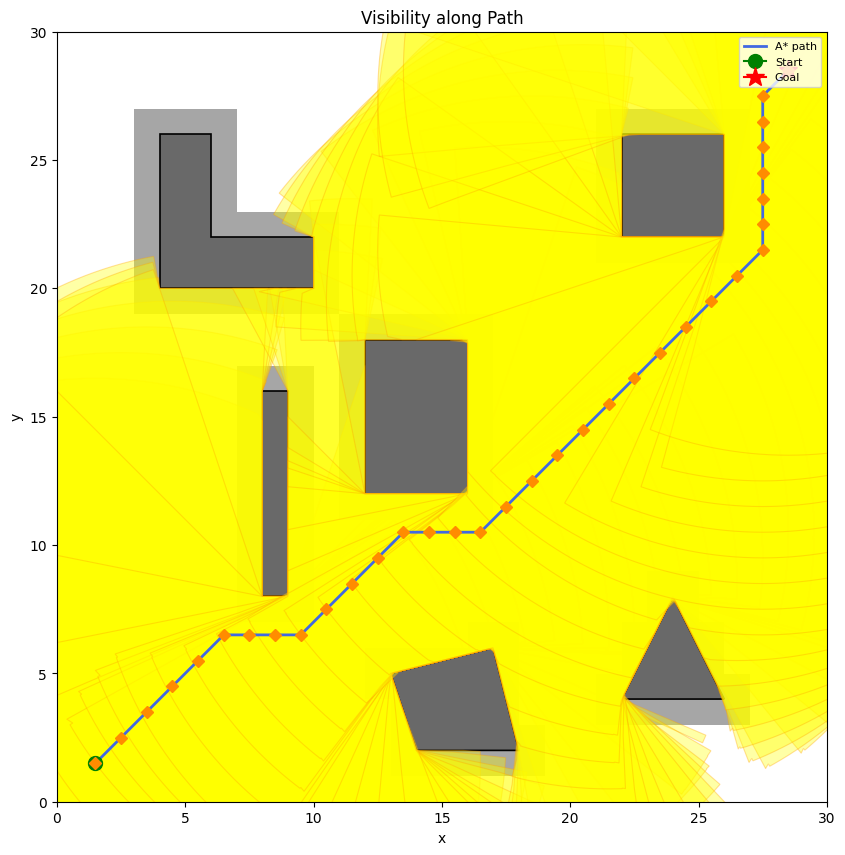

In [6]:
visibility_polygons: list = compute_path_visibility(
    path, map_env.obstacles, max_radius
)

fig, ax = plt.subplots(figsize=(10, 10))
plot_map(ax, map_env)
plot_grid(ax, map_env)
plot_all_visibility(ax, path, visibility_polygons)
plot_path(ax, path)
plt.show()